### Saturation curve fittings

This script is designed to read in the data from the text file that contains the data from the analysis of ODMR curves the were part of an saturation curve data-set. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plot 
import os
import scipy.optimize as opt

Call in the data set as a pandas array. 

In [2]:
def get_odmr_data(file_location):
    """The data from the .dat file is called in and saved within a pandas table"""
    
    odmr_analysis = pd.read_table(file_location)
    
    return(odmr_analysis)

In [3]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 20})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

Code for generating the ODMR contrast vs microwave power graphs and saturation curve fittings

In [4]:
def get_ODMR_contrast(power, contrast_low, contrast_high, title):
    '''Create the graph for ODMR contrast vs microwave power for both ODMR dips.'''
    
    # Higher resolution microwave power scan to improve fitting curve to a curve.  
    high_res_power = np.linspace(power[0], power[len(contrast_low)-1], 100)
    
    # Create a plot environment. 
    fig, ax = plot.subplots()
    
    # scatter plot of the contrast vs microwave power.
    ax.scatter(power[0:len(contrast_low)], contrast_low, marker = 'x',
              color = 'k', label = 'Low frequnecy \ntransition contrast')
    
    # Curve fit optimisation for the contrast 
    P0 = [1, 0.1]
    coeff_low, errors_low = power_curve_optimisation(power[0:len(contrast_low)], 
                                                 contrast_low, P0)
    # Generate the saturation curve fit for the low frequnecy data. 
    y_fit_low = power_curve(high_res_power, 
                           coeff_low[0], coeff_low[1])
    
    # scatter plot of the contrast vs microwave power.
    ax.scatter(power[0:len(contrast_high)], contrast_high, marker = 'o',
              color = 'k', label = 'High frequnecy \ntransition contrast')
    # Curve fit optimisation for the contrast 
    coeff_high, errors_high = power_curve_optimisation(power[0:len(contrast_high)], 
                                                 contrast_high, P0)
    # Generate the saturation curve fit for the High frequnecy data
    y_fit_high = power_curve(high_res_power, 
                           coeff_high[0], coeff_high[1])
    
    # If the data is microwave power vs ODMR contrast, then the saturation curve is plotted.     
    if title == 'Microwave Power (mW)':
        # Plot contrast vs microwave power for lower resonant freq.
        plot.plot(high_res_power, y_fit_low, label = 'Low frequnecy \nsaturation curve fit')
            
        # Plot the saturation curve for high frequency data. 
        plot.plot(high_res_power, y_fit_high, label = 'High frequnecy \nsaturation curve fit',
                  linestyle = '--')
    
    # Find the maximum value of contrast for graph limits. 
    maxi = [max(contrast_low), max(contrast_high)]
    mini = [min(contrast_low), min(contrast_high)]
    
    # format plot labels
    ax.set_xlabel(title)
    ax.set_ylabel('Contrast (%)')
    ax.set_title('Contrast vs ' + title)
    ax.legend(loc = 'upper right')
    ax.set_ylim(np.floor(np.min(mini)-1), np.ceil(np.max(maxi)+1))
    
    return(fig, ax, coeff_low, errors_low, coeff_high, errors_high)

In [5]:
def power_curve(P_uw, c_inf, P_sat):
    ''' Creates a power dependence curve.
    p_uW = power sweep
    y = Contrast as a functin of applied power, 
    c_inf = maximum ODMR contrast
    P_sat = stauration power.'''
    
    y = (c_inf * P_uw)/(P_uw + P_sat)
    
    return(y)

In [6]:
def power_curve_optimisation(x, y, P0):
    '''The saturation curve optimisation code.
    Outputs the coefficients of the curve fitting and the associated error.'''
    P = P0 # inital values variable.
    
    coeffs, confidence = opt.curve_fit(power_curve, x, y, P) # curve fit optimization
    opt_error = np.sqrt(np.diag(confidence)) # error calculation
    
    return(coeffs, opt_error)

Code for FWHM vs Microwave power plot/fit. 

In [7]:
def plot_fwhm(power, fwhm1, fwhm2, title):
    '''Code for plotting FWHM vs power, generalised for either Microwave power or laser power. '''
    fig2, ax2 = plot.subplots()
    
    # Plot both high and low resonant frequnecy dip FWHM on the same graph.
    ax2.scatter(power[0:len(fwhm1)], fwhm1, marker = 'x', label = 'Low frequency \nFWHM data')
    ax2.scatter(power[0:len(fwhm2)], fwhm2, marker = 'o', label = 'High frequency \nFWHM data')
    
    # Format graph. 
    ax2.set_xlabel(title)
    ax2.set_ylabel('FHWM (MHz)')
    ax2.set_title('FWHM vs ' + title)
    ax2.legend(loc='upper right')
    
    return(fig2, ax2)

Code for the off resonant signal vs power. 

In [8]:
def off_res_sig(power, off_res_sig, title):
    '''Plots the off-resonant signal from the NDs vs power, this is only really relavant
    for when testing contrast vs laser power. In which case the saturation curve is plotted.'''
    
    # Higher resolution microwave power scan to improve fitting curve to a curve.  
    high_res_power = np.linspace(power[0], power[len(off_res_sig)-1], 100)
    fig3, ax3 = plot.subplots()
    
    ax3.scatter(power[0:len(off_res_sig)], off_res_sig, marker = 'x', 
                label = 'off resonant signal')
    
    # Curve fit optimisation for the off_res_signal
    P0 = [1000, 20]
    coeffs, errors = power_curve_optimisation(power[0:len(off_res_sig)], 
                                                 off_res_sig, P0)
    
    # Generate satration curve fit. 
    y_fit = power_curve(high_res_power, coeffs[0], coeffs[1])
    
    # Plot saturation curve if we are exploring laser power vs contrast. 
    if title != 'Microwave Power (mW)':
        plot.plot(high_res_power, y_fit, label = 'Fitted Saturation curve')
        print(coeffs)
    
    #format graph. 
    ax3.set_xlabel(title)
    ax3.set_ylabel('Off Resonant Signal (per unit dwell time)')
    ax3.set_title('Off resonant signal vs ' + title)
    ax3.legend(loc='lower right')
    
    return(fig3, ax3)

Code for the plotting of the r squared value vs microwave power. 

In [9]:
def r_squared_plot(power, r_squared, title):
    '''Plot the r squared value for the ODMR data. '''
    
    fig4, ax4 = plot.subplots()
    
    ax4.scatter(power[0:len(r_squared)], r_squared, marker = 'x', 
                label = 'R squared values')
    
    # Format graph. 
    ax4.set_xlabel(title)
    ax4.set_ylabel('R squared value')
    ax4.set_title('R squared vs ' + title)
    ax4.legend(loc='lower right')
    
    return(fig4, ax4)

The following code generates a folder in which to save the graphs that are genereated as a part of this program. 

In [18]:
def save_data(date, ND, fig1, fig2, fig3, fig4):
    
    # Set save folder. 
    destination_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\20210430\\power_sweep\\Mirror_Flat-1_unit_mode_5\\analysis\\'
    output_data_file = destination_folder + date + 'Power_curves' + '.dat'
    
    print(destination_folder)
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        
        # Checking the output file exists and creating and initialising it if not
    
#    if os.path.isfile(output_data_file) == False:
#        with open(output_data_file, "w") as wf:
#            wf.write('File name' +  '\t' + 'ND' + '\t' +
#                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
#                     'Resonant frequency 1 contrast (%)' + '\t' + 
#                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
#                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
#                     'Resonant frequency 2 contrast (%)' + '\t' + 
#                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\t' + 
#                     'Off Res Fluorescence intensity (per dwell time)' + '\t' + 
#                     'R^2 for fitting' +'\n')
#    # Writing contrast dip description to the .dat file
    
#    with open(output_data_file, "a") as wf:
#        wf.write(file_ID + ' \t' +  str(nd) + '\t' +
#                 str(coeffs[1]) + " \t"  + str(opt_error[1]) + " \t" + 
#                 str(fitted_contrast[0]*100) + " \t"  +  
#                 str(abs(coeffs[2])*1000) + " \t" + str(opt_error[2]*1000) + " \t" + 
#                 str(coeffs[4]) + " \t"  + str(opt_error[4]) + " \t" + 
#                 str(fitted_contrast[1]*100) + " \t" +
#                 str(abs(coeffs[5])*1000) + " \t" + str(opt_error[5]*1000) + " \t" + 
#                 str(coeffs[6]) + " \t" +str(r_squared) + '\n')
        
    # Saving a plot of the raw data to a folder. 
    fig1.savefig(destination_folder + 'ODMR_contrast_vs_power.pdf', transparent = True)    
    fig1.savefig(destination_folder + 'ODMR_contrast_vs_power.png', transparent = True) 
    
    fig2.savefig(destination_folder + 'FWHM_vs_power.pdf', transparent = True)    
    fig2.savefig(destination_folder + 'FWHM_vs_power.png', transparent = True) 
    
    fig3.savefig(destination_folder + 'off_res_sig_vs_power.pdf', transparent = True)    
    fig3.savefig(destination_folder + 'off_res_sig_vs_power.png', transparent = True) 
    
    fig4.savefig(destination_folder + 'R_squared_vs_power.pdf', transparent = True)    
    fig4.savefig(destination_folder + 'R_squared_vs_power.png', transparent = True) 

Download the data from the text file specified in lines 3-6, create the microwave power array and seperate the data out into new panda arrays corresponding to the nanodiamond that the data was recorded from

In [30]:
# Create the file location.

date = '20210430'
folder_name = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\20210430\\power_sweep\\Mirror_Flat-1_unit_mode_5\\'
file_name = date + '_NVScan_double_peak_analysis'

# Get the data from the text file into a pandas array.
odmr_analysis = get_odmr_data(folder_name + file_name + '.dat')

#title = 'Microwave Power (mW)'
title = r'Laser power ($\mu$W)'
print(title)

# Input how many NDs are used in the data set
number_of_NDs = 1

# Microwave Power array 
m_power_dBm = np.array([-3, 0, 3, 6, 9, 12, 15])
m_power_dBm_sample = m_power_dBm + 20

## Microwave power in milli-Watts
#power = 0.001 * 10**((m_power_dBm_sample)/10.0)

# Set the laser powers used throughout the experiment. 
laser_power = [1.46, 2.60, 5.28, 10.52, 20.33, 30.70, 40.5, 51.6, 
              61.21, 70.51, 81.0, 90.2, 102.3, 124.8]

power = laser_power


# Sort analysis data into smaller sub-tables based on the nanodiamond number. 
nd1 = odmr_analysis[odmr_analysis['ND']==1]
#nd2 = odmr_analysis[odmr_analysis['ND']==2]
#nd3 = odmr_analysis[odmr_analysis['ND']==3]
#nd4 = odmr_analysis[odmr_analysis['ND']==4]
#nd5 = odmr_analysis[odmr_analysis['ND']==5]

Laser power ($\mu$W)


Create the graphs for contrast vs microwave power graph.

Also add the saturation trend line to the data.



[4.69044664 0.24024861] [ 3.80162288 -0.32902775]


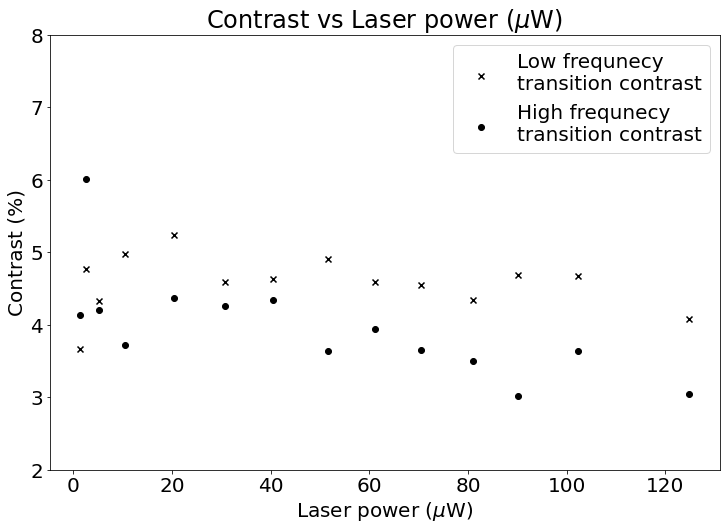

In [31]:
#Set plot parameters 
set_plot_params()

# Make a generic nd variable so that I only have to change 1 thing in the scripts each time I want to change ND. 
nd = nd1

#Create the figure for the ODMR contrast vs Microwave power. 
fig, ax, coeff_low, errors_low, coeff_high, errors_high = get_ODMR_contrast(power, 
                                                                            nd['Resonant frequency 1 contrast (%)'], 
                                                                            nd['Resonant frequency 2 contrast (%)'], 
                                                                           title)
print(coeff_low, coeff_high)

Generate graphs for the FWHM of the double lorentz curve fitting with increase microwave power. 

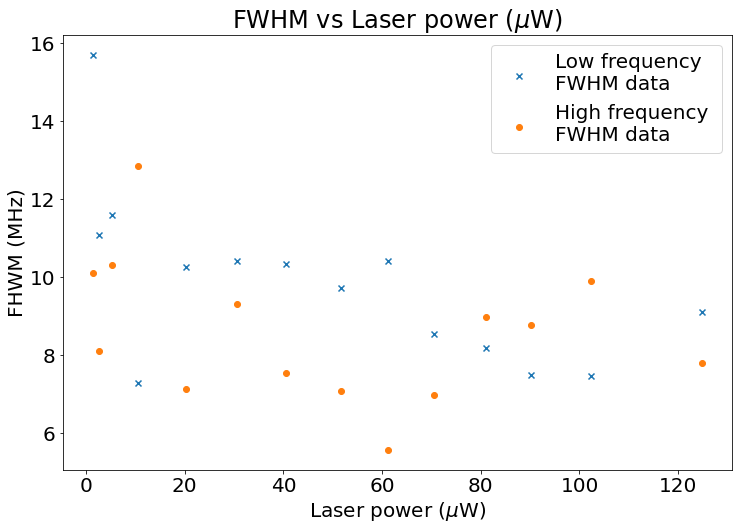

In [32]:
fig2, ax2 = plot_fwhm(power, nd['FWHM 1 (MHz)'], nd['FWHM 2 (MHz)'], title)

Generate a graph of the off-resonant signal vs microwave power. 

[45144.55819739   918.92905227]


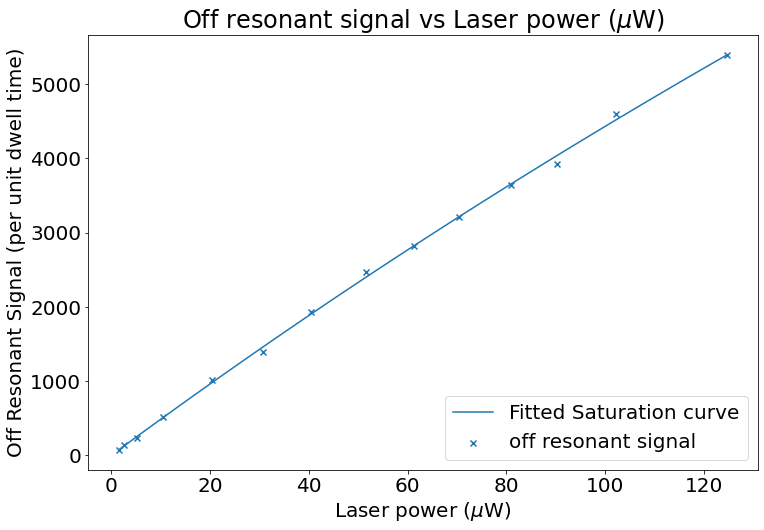

In [33]:
fig3, ax3 = off_res_sig(power, nd['Off Res Fluorescence intensity (per dwell time)'], title)
# Also gives the saturation curve details for the plot.

Make a plot of the r squared value vs microwave power. 

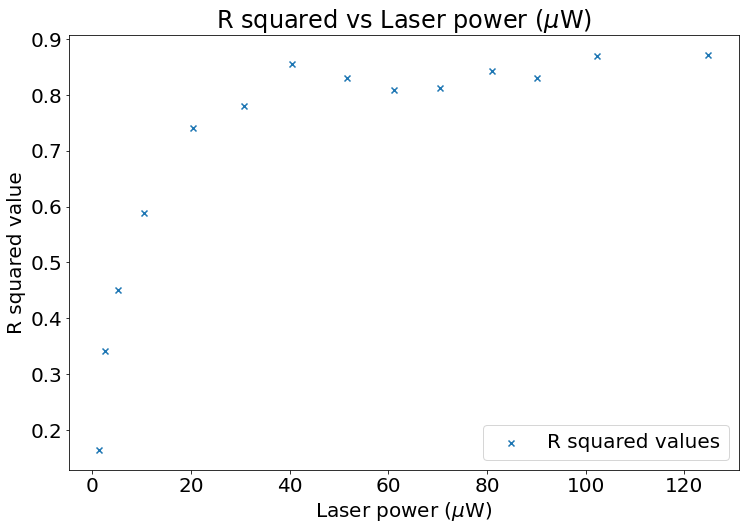

In [34]:
fig4, ax4 = r_squared_plot(power, nd['R^2 for fitting'], title)

Save the data

In [24]:
ND_number = nd['ND'].mean()

save_data(date, ND_number, fig, fig2, fig3, fig4)

I:\Science\Physics-Nanobiophotonics\Group\User Data Analysis\Ryans Data (2018-2021)\ODMR\20210430\power_sweep\Mirror_Flat-1_unit_mode_5\analysis\


In [122]:
print(nd1)

              File name  ND  Resonant frequency 1 (GHz)  \
0   20210217_NVScan_06    1                    2.863300   
3   20210217_NVScan_11    1                    2.862446   
8   20210217_NVScan_16    1                    2.862976   
13  20210217_NVScan_21    1                    2.862344   
18  20210217_NVScan_26    1                    2.861933   
23  20210217_NVScan_31    1                    2.860999   
28  20210217_NVScan_36    1                    2.860848   
33  20210217_NVScan_41    1                    2.860688   
38  20210217_NVScan_46    1                    2.861322   
43  20210217_NVScan_51    1                    2.859198   

    Error Resonant frequency 1 (GHz)  Resonant frequency 1 contrast (%)  \
0                           0.001112                           8.228383   
3                           0.000580                           7.565921   
8                           0.000377                           7.985477   
13                          0.000282              